# Decision Trees
We'll start by building a decision tree and examining how it works

In [189]:
from IPython.display import IFrame, Image
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

chapter_imgs = 'images/decision_trees/'

In [190]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [191]:
# Where to save the figures
import os 

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

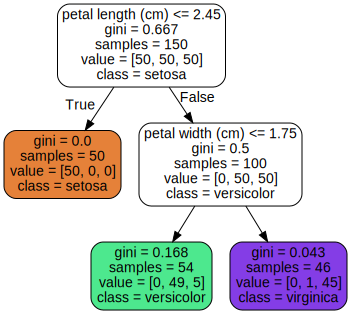

In [192]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf, 
    out_file= os.path.join(IMAGES_PATH, "iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

By looking at the diagram above we can see how the decision tree makes a prediction. 

Suppose we find an iris flower with petal length <= 2.45cm. The first node evaluates to true, we move to a leaf node and find our class.

However if we find a flower with petal length >2.45 we move to the next node on the right. It is not a leaf node so we ask another question: is the petal width <= 1.75cm? If so we classify it as versicolor otherwise as virginica.

*Note*: One of the advantages of decision trees is that they need little to no data preparation, feature scaling or centering.

You'll note that each node has various attributes. Here's their definition

**samples:** How many training instances it applies to. E.g. 100 instances have  petal length >2.45 (depth 1, right) and of those 54 have petal width <= 1.75cm and 46 greater than that.

**value:** How many training instances of each class this node applies to. E.g. bottom right (purple) node applies to 0 *iris setosa*, 1 *iris versicolor* and *45 iris virginica*.

The **gini** attribute measures how *pure* a node is. A node is pure (gini=0) if all training instances it applies to belong to the same class.

For example the orange node has gini=0 because all training instances are *iris setosa* instances. More formally, the Gini impurity is defined as

$$ G_i = 1 - \sum^{n}_{k=1}p_{i,k}^2$$

Where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node

For example, the green node has gini score equal to
$$ 1 - (0/54)^2 - (49/54)^2 - (5/54)^2 \approx 0.168 $$ 

In [193]:
scale = [0.00, 0.33, 0.66, 1.00]
c_colors = ['#9898ff', '#a0faa0', '#fafab0']
cscale = sorted(
    [(val, c) for val,c in zip(scale, c_colors)] +
    [(val, c) for val,c in zip(scale[1:], c_colors)]
)

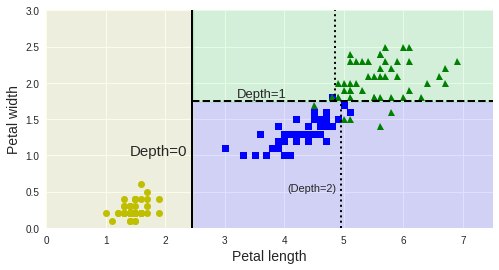

In [194]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

# save_fig("decision_tree_decision_boundaries_plot")
plt.show()

In the image above we can see the decision tree boundaries. The solid black line represents the split of the root node. Since the blue area is pure, it cannot be split any further. 

The decision tree then performs it's second split at width=1.75, represented by the dotted line. Since we set max depth=2, there are no more splits, however increasing depth increases the fit.

Decision Trees are an example of a *White box* model. It is easy to understand and explain why it makes its decision. In contrast, Random Forests and Neural Nets are highly accurate, but very hard to explain, and are called *black box* models.

### Class Probabilities

Decision trees can estimate the probability an instance belongs to a class *k* as follows.

- Traverse to the the leaf node for this instance
- Return ratio of training instances of class *k* in this node

For example, if we found a flower with petal length 5 and petal width 1.5 we get the following

In [9]:
for proba, cls in zip(tree_clf.predict_proba([[5, 1.5]])[0], iris['target_names']):
    print(f'Class {cls} probability: {proba:0.3f}')
    
print("Prediction class: ", tree_clf.predict([[5, 1.5]]))

Class setosa probability: 0.000
Class versicolor probability: 0.907
Class virginica probability: 0.093
Prediction class:  [1]


Note that any new instance that probabilities are identical for any instance located in a leaf node.

## The CART algorithm

Scikit-Learn uses the *Classification and Regression Tree* algorithm. It works as follows

Split the training set in two using a single feature $k$ and threshold $t_k$. To choose $k$ and $t_k$, search for the pair $(k, t_k)$ that produces the purest subsets (weighted by size). The equation to be minimized is 

$$ J(k, t_k) = \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}} $$

where $$\begin{cases} 
        G_{\text{left/right}} & \text{measures the impurity of the left/right subset}\\
        m_{\text{left/right}} & \text{number of instances on the left/right subset}
        \end{cases}$$


Once this first split is done, it recursively splits the subsets using the same logic, stopping once it reaches maximum depth (hyperparameter) or it cannot find a split that will reduce impurity.

Some other parameters that control stopping conditions are *min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes*

The CART Algorithm is an example of a greedy algorithm. It searches for the optimal split at the top leve, not caring whether that will happen several splits later. A greedy algorithm produces a solution that is good, but not guaranteed to be optimal. Finding the optimal tree is known to be an NP-Complete problem.

### Computational Complexity

To make a prediction, we need to traverse a tree. Decision Trees are approximately balanced thus has roughly $O(\log_2{m})$ nodes. Since each node requires only checking one feature, the overall complexity is $O(\log_2{m})$. Thus predictions are very fast.

The algorithm compares at most all features (less if *max_features* is set). It does so on all samples at each node resulting in $O(n\times m\log_2{m})$ complexity.

For small training sets, you can pre-sort the data (pre-sort=True), but this slows down training considerably for large training sets.

## Gini Impurity or Entropy

The default impurity measure is the Gini coefficient, discussed above. An alternative measure is *entropy* impurity, which can be set by changing the *criterion* hyperparameter. In machine learning, a set's entropy is zero when it contains instances of only one class. Here's the formal definition

$$ H_i = - \mathop{\sum_{k=1}}_{p_{i,k} \neq 0}^{n}p_{i,k}\log_2(p_{i,k}) $$

Where $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the $i^{th}$ node

In practice, using either Gini or Entropy impurity leads to similar trees. Gini is faster to compute so it is a good default.

However, when they differ, Gini tends to isolate the most frequent class on its own branch of the tree while entropy products more balanced trees.

More information [here](https://sebastianraschka.com/faq/docs/decision-tree-binary.html)

### Regularization Hyperparameters

Decision Trees make very few assumptions about the data (unlike linear models, which assume the data is linear, for example). If left unconstrained the tree structure will adapt itself to the training data, most likely overfitting it. Such a model is called a *nonparametric model*, because the number of parameters is not determined prior to training, so the model structure is free to stick close to the data. In contrast, a *parametric model* has a pre-determined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting but increasing risk of underfitting.

The parameters that regularize a Decision Tree during training are
- **max_depth**, how deep can the tree grow
- **min_samples_split**, the minimum number of samples a node must have before it can be split
- **min_samples_leaf**, minimum number of samples a leaf node must have
- **min_weight_fraction_leaf**, same as above, but expressed as a fraction of the total number of weighted instances
- **max_leaf_nodes**, maximum number of leaf_nodes
- **max_features**, maximum number of features evaluated for splitting at each node

*Side note*

Other algorithms first train the tree without restrictions and then prune it by deleting unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the $\chi_2$ test are used. The null hypothesis is that the improvement was the result of chance. If the test's *p-value* is greater than the threshold we fail to reject the null hypothesis (i.e. the improvement was result of chance) and delete those leaf nodes. We repeat untill all necessary nodes have been pruned. 

# Regression

Decision trees can also be used for training Regression models. Below we create a noisy quadratic dataset and build a tree with max depth=2.

In [197]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [198]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

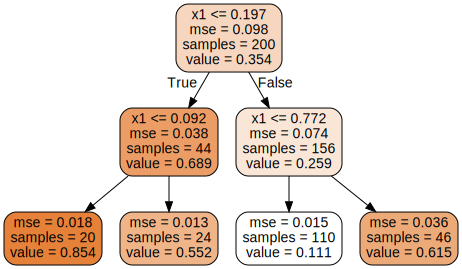

In [199]:
export_graphviz(
        tree_reg,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

The tree behaves similarly to a classification tree, but instead of predicting a class, it predicts a value. 

For example if we have a new point with $x_1=0.6$, we traverse the tree starting at the root and eventually reach the node which predicts value = 0.111. This prediciton is the average target value of 110 training instances associated with this node, resulting in a mean squared error of 0.015

Below a plot of a predictions made by this trees with max depth 2 and 3

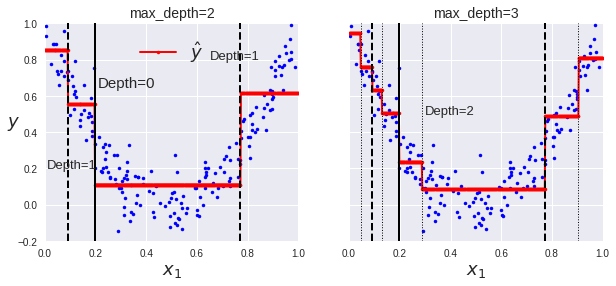

In [200]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

Note how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value

The CART algorithm works similarly to the classification algorithm, but instead of minimizing impurity, the focus now is to minimize the MSE

$$ J(k, t_k) = \frac{m_{\text{left}}}{m}MSE_{\text{left}} + \frac{m_{\text{right}}}{m}MSE_{\text{right}} $$

where $$\begin{cases} 
        MSE_{\text{node}} & \sum_{i \in \text{node}}(\hat{y} - y^{(i)})^2\\
        \hat{y}_{node} & \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}}y^{(i)}
        \end{cases}$$

And just like their classification counterparts, regression trees are prone to overfitting if not regularized. The figures below show a tree grown with no restrictions and another with only the min_samples_leaf parameters set to 10

In [58]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)

tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

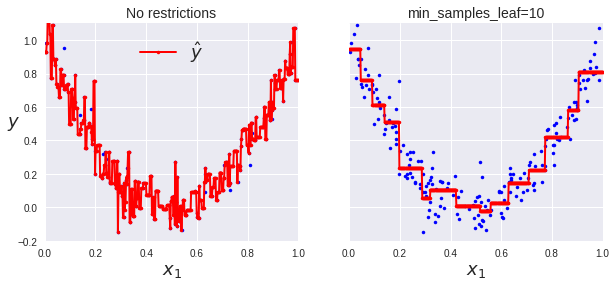

In [202]:


tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Instability

Decision trees are very simple to use and understand, however they also have their limitations.

First, you might have noticed that they love creating orthogonal boundaries (i.e. splits are perpendicular to an axis). Thus if a training set is rotated, it will greatly affect the decision tree.

The example below shows a linearly separable dataset being easily split by a decision tree. However rotating the dataset by 45 degrees leaves the decision boundary unecessarily convoluted.

Although both trees fit the training set perfectly, it is unlikely the one on the right will generalize well.

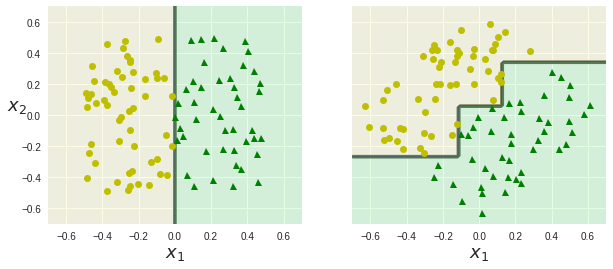

In [204]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

plt.show()

One way to limit this problem is to use PCA, which often results in a better orientation of the training data

More generally, the main issue with Decision Trees is that they are very sensitive o small variation in the training data. 

For example, removing the widest Iris versicolor from the training set and plotting the boundaries yields a very different model

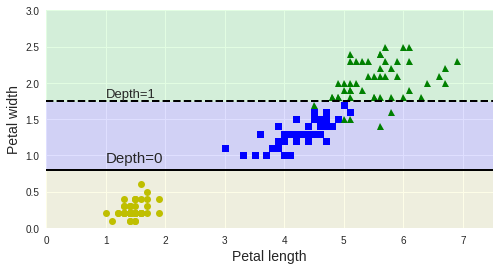

In [206]:
X = iris.data[:, 2:] # petal length and width
y = iris.target
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()

In fact, since the algorithm used by scikit-learn is stochastic, running without setting the random_state hyperparameter can yield different results.